# 元のデータから特徴量を抽出してh5ファイルに保存

In [2]:
import os
import pathlib

import h5py
import uproot_methods
import awkward
import numpy as np # < 1.24.0
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## [参考にしたプログラムでの前処理の様子](https://github.com/hqucms/ParticleNet/blob/master/tf-keras/keras_train.ipynb)

In [2]:
import logging
logging.basicConfig(level=logging.DEBUG, format='[%(asctime)s] %(levelname)s: %(message)s')

In [3]:
def _transform(dataframe, start=0, stop=-1, jet_size=0.8):
    from collections import OrderedDict
    v = OrderedDict()

    df = dataframe.iloc[start:stop]
    def _col_list(prefix, max_particles=200):
        return ['%s_%d'%(prefix,i) for i in range(max_particles)]
    
    _px = df[_col_list('PX')].values
    _py = df[_col_list('PY')].values
    _pz = df[_col_list('PZ')].values
    _e = df[_col_list('E')].values
    
    mask = _e>0
    n_particles = np.sum(mask, axis=1)

    px = awkward.JaggedArray.fromcounts(n_particles, _px[mask])
    py = awkward.JaggedArray.fromcounts(n_particles, _py[mask])
    pz = awkward.JaggedArray.fromcounts(n_particles, _pz[mask])
    energy = awkward.JaggedArray.fromcounts(n_particles, _e[mask])

    p4 = uproot_methods.TLorentzVectorArray.from_cartesian(px, py, pz, energy)
    pt = p4.pt

    jet_p4 = p4.sum()
    print(jet_p4.pt.shape)

    # outputs
    _label = df['is_signal_new'].values
    v['label'] = np.stack((_label, 1-_label), axis=-1)
    v['train_val_test'] = df['ttv'].values
    
    v['jet_pt'] = jet_p4.pt
    v['jet_eta'] = jet_p4.eta
    v['jet_phi'] = jet_p4.phi
    v['jet_mass'] = jet_p4.mass
    v['n_parts'] = n_particles

    v['part_px'] = px
    v['part_py'] = py
    v['part_pz'] = pz
    v['part_energy'] = energy

    v['part_pt_log'] = np.log(pt)
    v['part_ptrel'] = pt/v['jet_pt']
    v['part_logptrel'] = np.log(v['part_ptrel'])

    v['part_e_log'] = np.log(energy)
    v['part_erel'] = energy/jet_p4.energy
    v['part_logerel'] = np.log(v['part_erel'])

    v['part_raw_etarel'] = (p4.eta - v['jet_eta'])
    _jet_etasign = np.sign(v['jet_eta'])
    _jet_etasign[_jet_etasign==0] = 1
    v['part_etarel'] = v['part_raw_etarel'] * _jet_etasign

    v['part_phirel'] = p4.delta_phi(jet_p4)
    v['part_deltaR'] = np.hypot(v['part_etarel'], v['part_phirel'])
    
    for k in [k for k in v.keys() if k.startswith('part_')]:
        v[k] = np.where(np.isnan(v[k]), 0, v[k])

    def _make_image(var_img, rec, n_pixels = 64, img_ranges = [[-0.8, 0.8], [-0.8, 0.8]]):
        wgt = rec[var_img]
        x = rec['part_etarel']
        y = rec['part_phirel']
        img = np.zeros(shape=(len(wgt), n_pixels, n_pixels))
        for i in range(len(wgt)):
            hist2d, xedges, yedges = np.histogram2d(x[i], y[i], bins=[n_pixels, n_pixels], range=img_ranges, weights=wgt[i])
            img[i] = hist2d
        return img

#     v['img'] = _make_image('part_ptrel', v)

    return v

In [4]:
def convert(source, destdir, basename, step=None, limit=None):
    df = pd.read_hdf(source, key='table')
    logging.info('Total events: %s' % str(df.shape[0]))
    if limit is not None:
        df = df.iloc[0:limit]
        logging.info('Restricting to the first %s events:' % str(df.shape[0]))
    if step is None:
        step = df.shape[0]
    idx=-1
    while True:
        idx+=1
        start=idx*step
        if start>=df.shape[0]: break
        if not os.path.exists(destdir):
            os.makedirs(destdir)
        output = os.path.join(destdir, '%s_%d.awkd'%(basename, idx))
        logging.info(output)
        if os.path.exists(output):
            logging.warning('... file already exist: continue ...')
            continue
        v=_transform(df, start=start, stop=start+step)
        awkward.save(output, v, mode='x')

In [5]:
srcDir = '/home/suzukiy/Downloads/t-quark-tagging-dataset'
destDir = "./processed"

In [25]:
# conver training file
convert(os.path.join(srcDir, 'train.h5'), destdir=destDir, basename='train_file')

[2023-01-25 22:45:50,420] INFO: Total events: 1211000
[2023-01-25 22:45:50,421] INFO: ./processed/train_file_0.awkd


(1211000,)


/home/suzukiy/miniconda3/envs/weaver/lib/python3.10/site-packages/uproot_methods/classes/TLorentzVector.py:189: RuntimeWarning: invalid value encountered in sqrt
  return self._trymemo("mass", lambda self: self.awkward.numpy.sqrt(self.mag2))


In [10]:
# conver validation file
convert(os.path.join(srcDir, 'val.h5'), destdir=destDir, basename='val_file')

[2023-01-22 20:32:16,178] INFO: Total events: 403000
[2023-01-22 20:32:16,178] INFO: ./processed/val_file_0.awkd


In [11]:
# conver testing file
convert(os.path.join(srcDir, 'test.h5'), destdir=destDir, basename='test_file')

[2023-01-22 20:32:23,284] INFO: Total events: 404000
[2023-01-22 20:32:23,284] INFO: ./processed/test_file_0.awkd
/home/suzukiy/miniconda3/envs/weaver/lib/python3.10/site-packages/uproot_methods/classes/TLorentzVector.py:189: RuntimeWarning: invalid value encountered in sqrt
  return self._trymemo("mass", lambda self: self.awkward.numpy.sqrt(self.mag2))


In [6]:
with awkward.load(os.path.join(destDir, 'train_file_0.awkd')) as a:
    for k in a.keys():
        print(k, a[k].shape)

label (1211000, 2)
train_val_test (1211000,)
jet_pt (1211000,)
jet_eta (1211000,)
jet_phi (1211000,)
jet_mass (1211000,)
n_parts (1211000,)
part_px (1211000,)
part_py (1211000,)
part_pz (1211000,)
part_energy (1211000,)
part_pt_log (1211000,)
part_ptrel (1211000,)
part_logptrel (1211000,)
part_e_log (1211000,)
part_erel (1211000,)
part_logerel (1211000,)
part_raw_etarel (1211000,)
part_etarel (1211000,)
part_phirel (1211000,)
part_deltaR (1211000,)


In [38]:
with awkward.load(os.path.join(destDir, 'train_file_0.awkd')) as a:
    jet_pt = a['jet_pt']
    jet_eta = a['jet_eta']
    part_pt_log = a['part_pt_log']

In [22]:
with awkward.load(os.path.join(destDir, 'train_file_0.awkd')) as a:
    n_parts = a['n_parts']
    part_ptrel = a['part_ptrel']

## PyTorchに向けた前処理

- 多分こんなことをしなくてもよくて、固定長の変数と、maskのarrayさえあれば大丈夫なはず。
- なので、TRorentzVectorの変換だけパクる

In [1]:
import os
import pathlib

import h5py
import uproot_methods
import awkward
import numpy as np # < 1.24.0
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import logging
logging.basicConfig(level=logging.DEBUG, format='[%(asctime)s] %(levelname)s: %(message)s')

def transform_hdf_to_fixed_length_array(df, start=0, stop=None, max_particles=200):
    from collections import OrderedDict
    v = OrderedDict()
    
    def _col_list(prefix, max_particles):
        return ['%s_%d'%(prefix,i) for i in range(max_particles)]

    if stop is None:
        stop = df.shape[0]
    df = df.iloc[start:stop]

    px = df[_col_list('PX', max_particles)].values
    py = df[_col_list('PY', max_particles)].values
    pz = df[_col_list('PZ', max_particles)].values
    energy = df[_col_list('E', max_particles)].values
    mask = (energy > 0)
    n_parts = mask.sum(1)
    
    p4 = uproot_methods.TLorentzVectorArray.from_cartesian(px, py, pz, energy)
    jet_p4 = uproot_methods.TLorentzVectorArray.from_cartesian(px.sum(1), py.sum(1), pz.sum(1), energy.sum(1))
    
    v['label'] = df['is_signal_new'].values
    v['ttv'] = df['ttv'].values
    
    v['jet_pt'] = jet_p4.pt
    v['jet_eta'] = jet_p4.eta
    v['jet_phi'] = jet_p4.phi
    v['jet_mass'] = jet_p4.mass
    v['jet_energy'] = jet_p4.energy
    
    v['n_parts'] = n_parts
    v['mask'] = mask[:,np.newaxis,:]
    
    v['part_px'] = px
    v['part_py'] = py
    v['part_pz'] = pz
    v['part_energy'] = energy
    
    v['part_pt_log'] = np.log(p4.pt)
    v['part_ptrel'] = p4.pt / jet_p4.pt[:, np.newaxis]
    v['part_logptrel'] = np.log(v['part_ptrel'])
    v['part_e_log'] = np.log(p4.energy)
    v['part_erel'] = p4.energy / jet_p4.energy[:, np.newaxis]
    v['part_logerel'] = np.log(v['part_erel'])
    v['part_raw_etarel'] = p4.eta - jet_p4.eta[:, np.newaxis]
    
    _jet_etasign = np.sign(v['jet_eta'])
    _jet_etasign[_jet_etasign==0] = 1
    v['part_etarel'] = v['part_raw_etarel'] * _jet_etasign[:, np.newaxis]
    
    def delta_phi(target, other):
        return (target.phi - other.phi[:,np.newaxis] + np.pi) % (2*np.pi) - np.pi
    
    v['part_phirel'] = delta_phi(p4, jet_p4)
    v['part_deltaR'] = np.hypot(v['part_etarel'], v['part_phirel'])
    
    for k in [kk for kk in v.keys() if kk.startswith('part_')]:
        v[k] = np.where(mask, v[k], 0)
    
    return v

def convert_to_hdf(source, destdir, basename, step=None, limit=None):
    df = pd.read_hdf(source, key='table')
    logging.info('Total events: %s' % str(df.shape[0]))
    if limit is not None:
        df = df.iloc[0:limit]
        logging.info('Restricting to the first %s events:' % str(df.shape[0]))
    if step is None:
        step = df.shape[0]
    idx=-1
    while True:
        idx+=1
        start=idx*step
        if start>=df.shape[0]: break
        if not os.path.exists(destdir):
            os.makedirs(destdir)
        output = os.path.join(destdir, '%s_%d.h5'%(basename, idx))
        logging.info(output)
        if os.path.exists(output):
            logging.warning('... file already exist: continue ...')
            continue
        v = transform_hdf_to_fixed_length_array(df, start=start, stop=start+step)
        with h5py.File(output, 'w') as f:
            for k in v.keys():
                f.create_dataset(k, data=v[k])
        logging.info('... done')

In [3]:
srcDir = '/home/suzukiy/Downloads/t-quark-tagging-dataset'
destDir = "./processed"

convert_to_hdf(os.path.join(srcDir, "train.h5"), destDir, 'train_file')
convert_to_hdf(os.path.join(srcDir, "test.h5"), destDir, 'test_file')
convert_to_hdf(os.path.join(srcDir, "val.h5"), destDir, 'val_file')

[2023-01-26 02:48:29,011] INFO: Total events: 1211000
[2023-01-26 02:48:29,012] INFO: ./processed/train_file_0.h5
/home/suzukiy/miniconda3/envs/weaver/lib/python3.10/site-packages/uproot_methods/classes/TLorentzVector.py:189: RuntimeWarning: invalid value encountered in sqrt
  return self._trymemo("mass", lambda self: self.awkward.numpy.sqrt(self.mag2))
/tmp/ipykernel_101876/2657180913.py:42: RuntimeWarning: divide by zero encountered in log
  v['part_pt_log'] = np.log(p4.pt)
/tmp/ipykernel_101876/2657180913.py:44: RuntimeWarning: divide by zero encountered in log
  v['part_logptrel'] = np.log(v['part_ptrel'])
/tmp/ipykernel_101876/2657180913.py:45: RuntimeWarning: divide by zero encountered in log
  v['part_e_log'] = np.log(p4.energy)
/tmp/ipykernel_101876/2657180913.py:47: RuntimeWarning: divide by zero encountered in log
  v['part_logerel'] = np.log(v['part_erel'])
/home/suzukiy/miniconda3/envs/weaver/lib/python3.10/site-packages/uproot_methods/classes/TLorentzVector.py:181: Runtime

In [2]:
var_jet = {}
with h5py.File('./processed/train_file_0.h5', 'r') as f:
    for k in f:
        if ("jet" in k) or ("label" in k):
            print(k)
            var_jet[k] = f[k][()]

jet_energy
jet_eta
jet_mass
jet_phi
jet_pt
label


In [3]:
df = pd.DataFrame.from_dict(var_jet)
df

,jet_energy,jet_eta,jet_mass,jet_phi,jet_pt,label
0,869.288574,-0.874543,37.394016,-2.400258,617.077026,0
1,594.615173,-0.360226,46.997341,0.578900,556.271301,0
2,989.005371,1.185970,61.648197,-1.471082,551.548889,0
3,1709.042603,-1.682899,52.098465,-0.657215,613.708679,0
4,1509.379028,-1.526301,174.350220,-2.894216,622.304382,0
...,...,...,...,...,...,...
1210995,1217.327393,-1.262488,161.610641,1.448675,632.174072,1
1210996,1487.626587,1.562551,163.697510,-1.644526,593.743530,1
1210997,645.437256,-0.148742,148.290436,0.952815,621.285889,1
1210998,1047.489136,1.181890,173.918091,-1.265011,579.133057,1


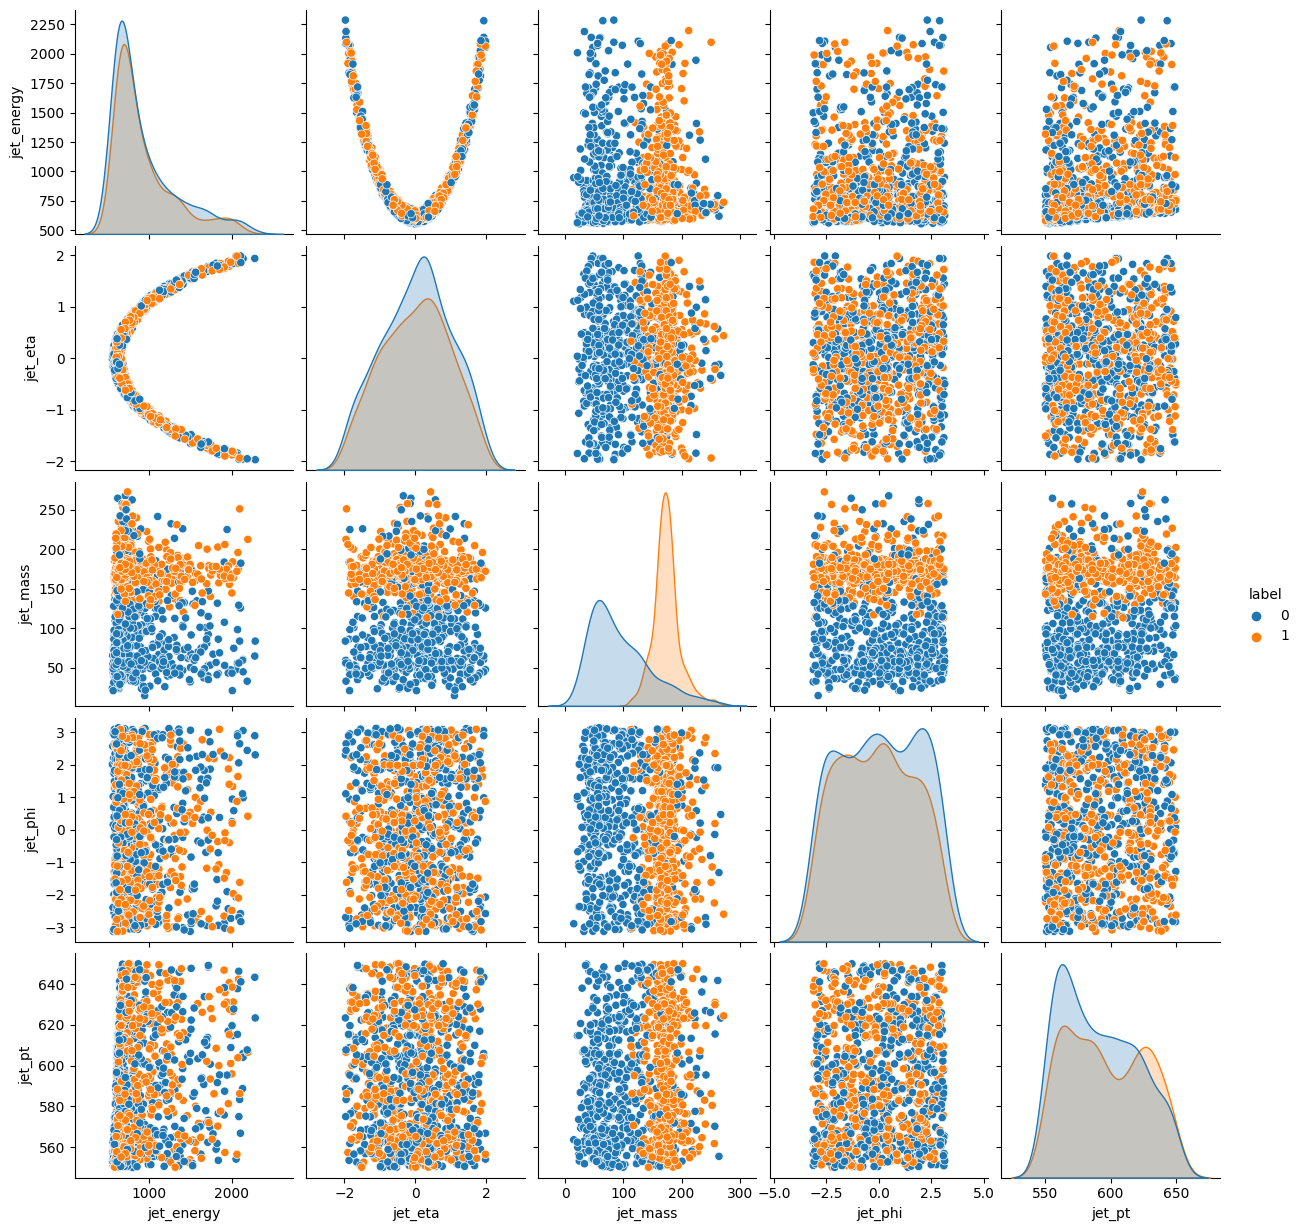

In [5]:
import seaborn as sns
# logging.disable(logging.DEBUG)

sns.pairplot(df[:1000], hue="label")
plt.show()

In [3]:
part_var_names = [
    "part_etarel",
    "part_phirel",
    "part_pt_log",
    "part_e_log",
    "part_logptrel",
    "part_logerel",
    "part_deltaR",
]

part_var = {}

with h5py.File('./processed/train_file_0.h5', 'r') as f:
    mask = f["mask"][()]
    label = f["label"][()]
    for k in part_var_names:
        print(k)
        part_var[k] = f[k][()]


part_etarel
part_phirel
part_pt_log
part_e_log
part_logptrel
part_logerel
part_deltaR


SyntaxError: keyword argument repeated: label (3392131536.py, line 10)

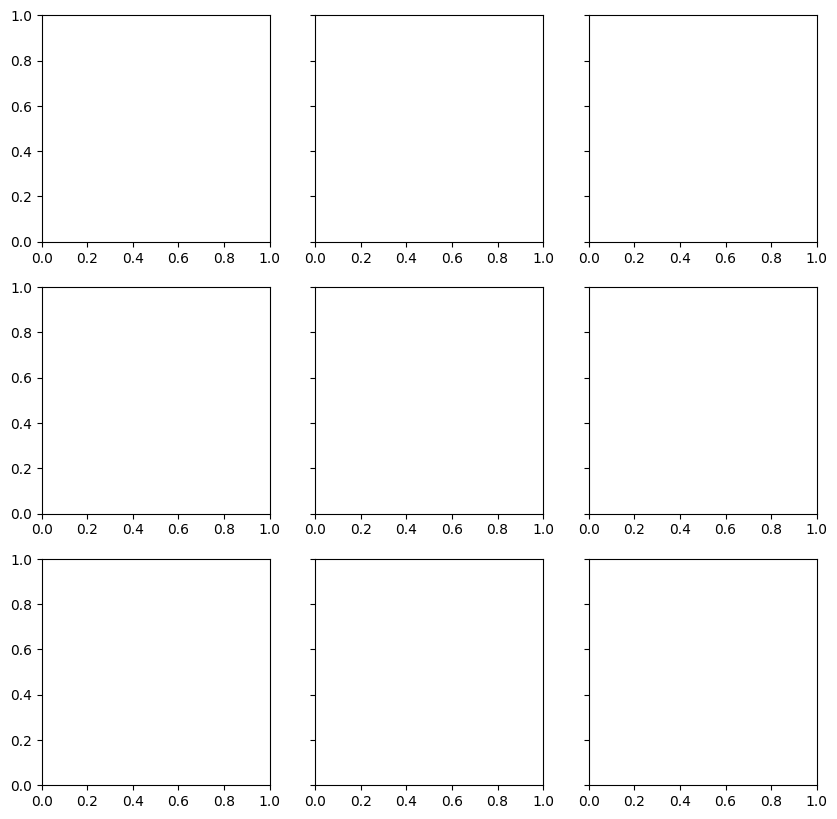

In [11]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10,10), sharey=True)

_mask = mask.squeeze()

for i, (k,v) in enumerate(part_var.items()):
    print(i, k)
    # print(v.shape)
    # print(mask.shape)
    bins = np.linspace(v[_mask].min(), v[_mask].max(), 100)
    ax[i//3,i%3].hist(v[label==1][_mask[label==1]], label="top", bins=bins, alpha=0.5, label="top")
    ax[i//3,i%3].hist(v[label==0][_mask[label==0]], label="QCD", bins=bins, alpha=0.5, label="QCD")
    ax[i//3,i%3].set(
        title=k,
        ylabel="n of particles",
    )
    ax[i//3,i%3].legend()
plt.show()